In [34]:
file = "inventarios/36_Elementos_JDE.csv"


Estadísticas por Ubicación:
--------------------------------------------------

Ubicación: P02009001
Items Totales: 78
Artículos Únicos: 69
Ratio de Duplicación: 1.13

Ubicación: P02009002
Items Totales: 65
Artículos Únicos: 58
Ratio de Duplicación: 1.12

Ubicación: P02009004
Items Totales: 25
Artículos Únicos: 25
Ratio de Duplicación: 1.00

Ubicación: P02009003
Items Totales: 13
Artículos Únicos: 13
Ratio de Duplicación: 1.00

Ubicación: P02010001
Items Totales: 1
Artículos Únicos: 1
Ratio de Duplicación: 1.00


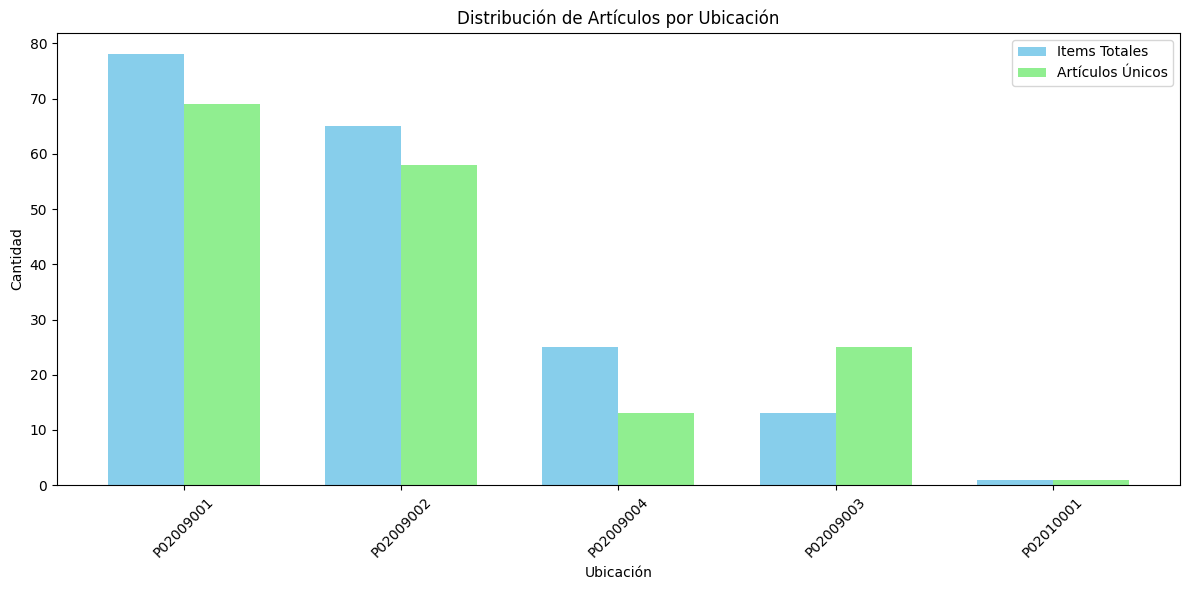

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def reads(ruta_archivo):
  
    df = pd.read_csv(ruta_archivo, sep=';')
    
    analisis = {}
    
    items_por_ubicacion = df['Ubicacion'].value_counts()
    articulos_unicos = df.groupby('Ubicacion')['CodigoArticulo'].nunique()
    for ubicacion in items_por_ubicacion.index:
        analisis[ubicacion] = {
            'total_items': items_por_ubicacion[ubicacion],
            'articulos_unicos': articulos_unicos[ubicacion],
            'ratio_duplicacion': items_por_ubicacion[ubicacion] / articulos_unicos[ubicacion]
        }
    
    plt.figure(figsize=(12, 6))
    x = range(len(items_por_ubicacion.index))
    width = 0.35
    plt.bar(x, items_por_ubicacion.values, width, label='Items Totales', color='skyblue')
    plt.bar([i + width for i in x], articulos_unicos.values, width, label='Artículos Únicos', color='lightgreen')
    plt.xlabel('Ubicación')
    plt.ylabel('Cantidad')
    plt.title('Distribución de Artículos por Ubicación')
    plt.xticks([i + width/2 for i in x], items_por_ubicacion.index, rotation=45)
    plt.legend()
    plt.tight_layout()

    print("\nEstadísticas por Ubicación:")
    print("-" * 50)
    for ubicacion, stats in analisis.items():
        print(f"\nUbicación: {ubicacion}")
        print(f"Items Totales: {stats['total_items']}")
        print(f"Artículos Únicos: {stats['articulos_unicos']}")
        print(f"Ratio de Duplicación: {stats['ratio_duplicacion']:.2f}")
    
    return analisis


analisis = reads(file)

Error al procesar el archivo: 'P02010001'


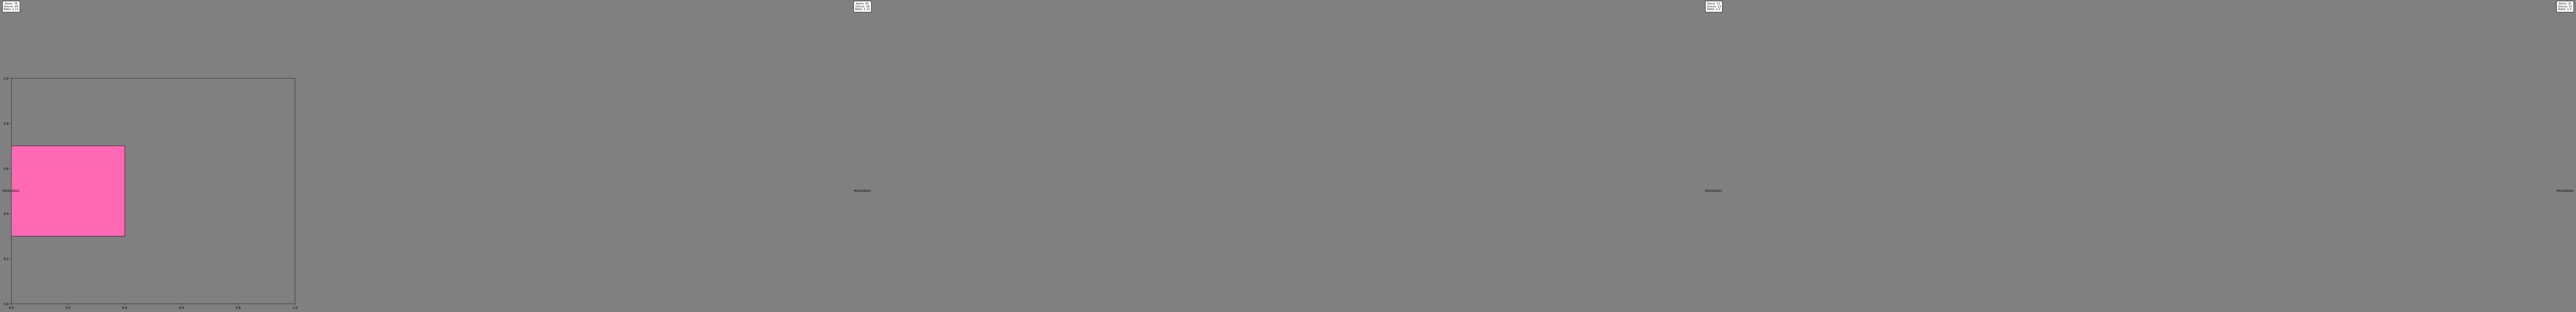

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def crear_diagrama_desde_csv(ruta_archivo):
    try:
        # Leer el archivo CSV
        df = pd.read_csv(ruta_archivo, sep=';', encoding='utf-8')
        df =df[df['Ubicacion'].str.startswith('P0200')]
        df['Fecha_lectura'] = pd.to_datetime(df['Fecha_lectura'])
        df_sorted = df.sort_values('Fecha_lectura')
        
       
        
        transiciones = []
        ubicacion_anterior = None
        contador = 1
        
        for _, row in df_sorted.iterrows():
            ubicacion_actual = row['Ubicacion']
            if ubicacion_anterior is not None and ubicacion_actual != ubicacion_anterior:
                transiciones.append({
                    'desde': ubicacion_anterior,
                    'hasta': ubicacion_actual,
                    'numero': contador,
                    'tiempo': row['Fecha_lectura']
                })
                contador += 1
            ubicacion_anterior = ubicacion_actual
        
        stats = {}
        for ubicacion in df['Ubicacion'].unique():
            items = df[df['Ubicacion'] == ubicacion].shape[0]
            unicos = df[df['Ubicacion'] == ubicacion]['CodigoArticulo'].nunique()
            stats[ubicacion] = {
                'items': items,
                'unicos': unicos,
                'ratio': round(items / unicos, 2) if unicos > 0 else 0
            }
        
        plt.figure(figsize=(15, 12), facecolor='#808080')
        ax = plt.gca()
        ax.set_facecolor('#808080')
        

        ubicaciones = sorted(df['Ubicacion'].unique())
        

        pos = {ubicacion: (i * 3, 0.5) for i, ubicacion in enumerate(ubicaciones)}
        
  
        colores_nodos = {
            ubicaciones[0]: '#FF69B4',  # Rosa
            ubicaciones[1]: '#B0E0E6',  # Azul
            ubicaciones[2]: '#98FB98',  # Verde
            ubicaciones[3]: '#FFFFE0',   # Amarillo
           
        }
        
   
        for node, (x, y) in pos.items():
            # Nodo
            rect = plt.Rectangle((x-0.4, y-0.2), 0.8, 0.4,
                               facecolor=colores_nodos[node],
                               edgecolor='black',
                               linewidth=1)
            ax.add_patch(rect)
            plt.text(x, y, node, horizontalalignment='center',
                    verticalalignment='center', fontsize=9)
            
       
            stats_text = f"Items: {stats[node]['items']}\n" \
                        f"Únicos: {stats[node]['unicos']}\n" \
                        f"Ratio: {stats[node]['ratio']}"
            plt.text(x, y+0.8, stats_text,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='black', alpha=1))

        altura_base = -1
        for i, t in enumerate(transiciones):
            x_desde = pos[t['desde']][0]
            x_hasta = pos[t['hasta']][0]
            y = altura_base - (i * 0.5) 

            es_regreso = ubicaciones.index(t['hasta']) < ubicaciones.index(t['desde'])
            color = 'blue' if es_regreso else 'red'

            arrow = patches.FancyArrowPatch(
                (x_desde, y),
                (x_hasta, y),
                color=color,
                arrowstyle='->',
                mutation_scale=20,
                linewidth=2
            )
            ax.add_patch(arrow)

            plt.text((x_desde + x_hasta)/2, y+0.2,
                    f"{t['numero']}\n{t['tiempo'].strftime('%H:%M:%S')}",
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    fontsize=8,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=1))
        
        plt.title('Secuencia de Movimientos', pad=20, fontsize=14)
        plt.axis('off')
        
        plt.xlim(-1, max(x for x,y in pos.values()) + 1)
        plt.ylim(altura_base - (len(transiciones) * 0.5) - 0.5, 2)

        plt.savefig(str(ruta_archivo)+'_ruta_de_vuelo_secuencial.png',
                   bbox_inches='tight',
                   facecolor='#808080',
                   dpi=300,
                   pad_inches=0.5)
        plt.close()
        
        return True
        
    except Exception as e:
        print(f"Error al procesar el archivo: {str(e)}")
        return False

# Ejecutar con el archivo
ruta_archivo = 'paste.txt'
if crear_diagrama_desde_csv(file):
    print(f"Diagrama creado exitosamente como {str(file)} 'ruta_de_vuelo_secuencial.png'")

In [33]:
import cv2
import numpy as np
import pandas as pd
from datetime import datetime

def crear_simulacion_desde_csv(ruta_archivo):

    df = pd.read_csv(ruta_archivo, sep=';')
    df['Fecha_lectura'] = pd.to_datetime(df['Fecha_lectura'])
    df_sorted = df.sort_values('Fecha_lectura')
    df_sorted =df_sorted[df_sorted['Ubicacion'].str.startswith('P0200')]

    transiciones = []
    ubicacion_anterior = None
    contador = 1
    
    for _, row in df_sorted.iterrows():
        ubicacion_actual = row['Ubicacion']
        if ubicacion_anterior is not None and ubicacion_actual != ubicacion_anterior:
            transiciones.append({
                'desde': ubicacion_anterior,
                'hasta': ubicacion_actual,
                'numero': contador,
                'tiempo': row['Fecha_lectura']
            })
            contador += 1
        ubicacion_anterior = ubicacion_actual
    

    stats = {}
    for ubicacion in df['Ubicacion'].unique():
        items = df[df['Ubicacion'] == ubicacion].shape[0]
        unicos = df[df['Ubicacion'] == ubicacion]['CodigoArticulo'].nunique()
        stats[ubicacion] = {
            'items': items,
            'unicos': unicos,
            'ratio': round(items / unicos, 2) if unicos > 0 else 0
        }
    

    width = 1280
    height = 720
    fps = 30
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(ruta_archivo) + '_simulacion_dron.mp4', fourcc, fps, (width, height))
    

    nodos = {
        'P02009001': (320, 100),
        'P02009002': (540, 100),
        'P02009003': (760, 100),
        'P02009004': (980, 100)
    }
    
    # Colores en formato BGR
    colores = {
        'adelante': (0, 0, 255),    # Rojo
        'retorno': (255, 0, 0),     # Azul
        'nodo1': (147, 20, 255),    # Rosa
        'nodo2': (255, 191, 0),     # Celeste
        'nodo3': (0, 255, 0),       # Verde
        'nodo4': (255, 255, 224)    # Amarillo claro
    }
    
    def crear_frame():
        frame = np.ones((height, width, 3), dtype=np.uint8) * 128  
        

        for i, (nombre, pos) in enumerate(nodos.items()):
     
            if i == 0:
                color = colores['nodo1']
            elif i == 1:
                color = colores['nodo2']
            elif i == 2:
                color = colores['nodo3']
            else:
                color = colores['nodo4']
       
            cv2.rectangle(frame, 
                         (pos[0]-50, pos[1]-25),
                         (pos[0]+50, pos[1]+25),
                         color, -1)
            cv2.rectangle(frame, 
                         (pos[0]-50, pos[1]-25),
                         (pos[0]+50, pos[1]+25),
                         (0,0,0), 1)  

            cv2.putText(frame, nombre, (pos[0]-45, pos[1]+8),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
            

            stats_text = [
                f"Items: {stats[nombre]['items']}",
                f"Únicos: {stats[nombre]['unicos']}",
                f"Ratio: {stats[nombre]['ratio']}"
            ]
            
            for j, text in enumerate(stats_text):
                cv2.putText(frame, text, (pos[0]-45, pos[1]-50-(j*20)),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)
        
        return frame
    
    def interpolar_posicion(pos1, pos2, step, total_steps):
        x = int(pos1[0] + (pos2[0] - pos1[0]) * (step / total_steps))
        y = int(pos1[1] + (pos2[1] - pos1[1]) * (step / total_steps))
        return (x, y)
    
    try:

        for t in transiciones:
            pos_inicial = nodos[t['desde']]
            pos_final = nodos[t['hasta']]
            

            es_retorno = list(nodos.keys()).index(t['hasta']) < list(nodos.keys()).index(t['desde'])
            color = colores['retorno'] if es_retorno else colores['adelante']

            pasos = 30
            for step in range(pasos + 1):
                frame = crear_frame()

                pos_actual = interpolar_posicion(pos_inicial, pos_final, step, pasos)
                
       
                cv2.circle(frame, pos_actual, 8, color, -1)
                

                cv2.putText(frame, 
                           f"Movimiento {t['numero']}: {t['desde']} -> {t['hasta']}", 
                           (10, height-60),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
                cv2.putText(frame, 
                           f"Tiempo: {t['tiempo'].strftime('%H:%M:%S')}", 
                           (10, height-30),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
                
                out.write(frame)
        

        out.release()
        print("Video guardado como 'simulacion_dron.mp4'")
        
    except Exception as e:
        print(f"Error durante la creación del video: {str(e)}")
        out.release()

crear_simulacion_desde_csv(file)

Video guardado como 'simulacion_dron.mp4'
